```Name: Wong Wen Bing```    
```Admin #: 230436M```  
```PEM GROUP: AA2303```

# **Part 2: Data Preparation and Understanding Notebook (2/3)** 
This part will comprise of the data understanding, data pre-processing and creating additional features through the cleaning the textual data. 

### **Install and Import Libraries**

In [1]:
pip install pandas nltk seaborn matplotlib tqdm scikit-learn textblob

Defaulting to user installation because normal site-packages is not writeable
  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
    --------------------------------------- 10.2/624.3 kB ? eta -:--:--
   - ------------------------------------- 20.5/624.3 kB 165.2 kB/s eta 0:00:04
   - ------------------------------------- 30.7/624.3 kB 187.9 kB/s eta 0:00:04
   -- ------------------------------------ 41.0/624.3 kB 178.6 kB/s eta 0:00:04
   --- ----------------------------------- 61.4/624.3 kB 252.2 kB/s eta 0:00:03
   ------ ------------------------------- 102.4/624.3 kB 368.6 kB/s eta 0:00:02
   ------------------------- -------------- 399.4/624.3 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 624.3/624.3 kB 1.9 MB/s eta 0:00:00
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
  Attempting uninstall: nltk
    Foun

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
import string
from textblob import TextBlob
import dill 
import pickle 

Load Data

In [3]:
dataset=pd.read_csv('train_set.csv')

In [4]:
dataset.head()

,Unnamed: 0,content,rating,airline
0,0,Southwest's Boarding Process has gotten comple...,3.0,Southwest Airlines
1,1,Flew Sydney to Auckland in January 2017 with t...,5.0,Emirates
2,2,NEVER fly with scoot. I booked a ticket almost...,1.0,Scoot
3,3,✅ Trip Verified | Melbourne to London return ...,3.0,Singapore Airlines
4,4,MAD-DXB-SYD economy. A380 great seats B777 imp...,3.0,Emirates


## <strong><ins> EDA </ins></strong>
We now conduct some exploratory analysis first to understand more about the dataet. 

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12209 entries, 0 to 12208
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  12209 non-null  int64  
 1   content     12209 non-null  object 
 2   rating      12207 non-null  float64
 3   airline     12209 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 381.7+ KB


In [6]:
dataset.head() 

,Unnamed: 0,content,rating,airline
0,0,Southwest's Boarding Process has gotten comple...,3.0,Southwest Airlines
1,1,Flew Sydney to Auckland in January 2017 with t...,5.0,Emirates
2,2,NEVER fly with scoot. I booked a ticket almost...,1.0,Scoot
3,3,✅ Trip Verified | Melbourne to London return ...,3.0,Singapore Airlines
4,4,MAD-DXB-SYD economy. A380 great seats B777 imp...,3.0,Emirates


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


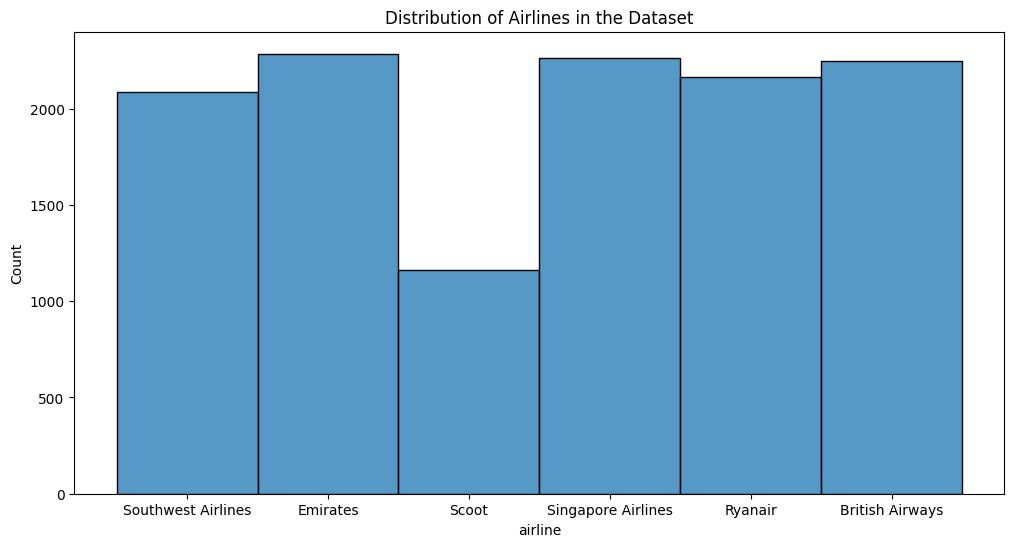

In [7]:
group=dataset.groupby(['airline']).count()
plt.figure(figsize=(12, 6))  
sns.histplot(dataset['airline'])
plt.title('Distribution of Airlines in the Dataset')
plt.show()

From the dataset above, we can observe that overall the dataset is rather balanced, however there are some airlines like southwest and scoot which are more skewed.

In [8]:
dataset.isnull().sum()

Unnamed: 0    0
content       0
rating        2
airline       0
dtype: int64

In [9]:
dataset.duplicated().sum()

0

We can observe that there are some null values that needs to be removed

## <strong><ins>Preprocessing Text</strong></ins>
We will now begin our preprocessing steps. We will first start by removing the null values. After we will create a series of functions to conduct datacleaning. To further streamline the process and package it such that it can be used for testing, we will use a data pipeline to assist us in doing so.

In [10]:
#remove null values
dataset=dataset.dropna()

We will now create a series of functions for the data pipeline to assist in our fast and rapid cleaning of words: 
- **lowercase**: convert the text to lowercase and remove additional whitespaces
- **filter_startwords**: remove starting words which are not relevant to the analysis such as trip verified or verified review
- **remove_stopwords**: remove stopwords and additional stopwords that were observed during the modelling process
- **remove_punctuation**: remove punctuations 
- **remove_others_lemmatise**: remove other additional words/characters that were not removed previously and lemmatisation of the word is conducted here to ensure standardisation.

In [11]:
#start off with converting to lowercase and remove any additional whitespaces
def lowercase(text): 
    text=text.lower()
    text=re.sub(r'\s\s+', ' ', text)
    return text

In [12]:
#remove starting words which are not relevant like trip verified/verified review 
def filter_startwords(text):
    text=re.sub(r'([^a-zA-Z]+trip verified[^a-zA-Z]+)', '', text)
    text=re.sub(r'([^a-zA-Z]+verified review[^a-zA-Z]+)', '', text)
    return text

In [13]:
def remove_stopwords(x): 
    stopwordss=stopwords.words('english')
    stopwordss.extend(['would','u', 'not'])
    words=word_tokenize(x)
    text=[]
    for word in words: 
        if word not in stopwordss: 
            text.append(word)
    return ' '.join(text)

In [14]:
import string
def remove_punctuation(x):
    punct=list(string.punctuation)
    text=[]
    words=word_tokenize(x)
    for word in words: 
        if word not in punct: 
            text.append(word)
    return ' '.join(text)

In [15]:
def remove_others_lemmatise(x): 
    lemma=WordNetLemmatizer() #lemmatization
    wordslist=['``', '`']
    words=word_tokenize(x)
    txt=[]
    for word in words: 
        if word not in wordslist: 
            if word == "n't": 
                word='not'
                txt.append(word)
            else:
                word=lemma.lemmatize(word)
                txt.append(word)
    return ' '.join(txt)

Once we are done creating the functions, we will activate the text preprocessing pipeline and then run the pipeline and will show the final text at the bottom. 

In [16]:
tqdm.pandas()
textpreprocessing_steps=Pipeline(steps=[
    ('lowercase', FunctionTransformer(lambda x:x.progress_apply(lowercase))),
    ('filer_start', FunctionTransformer(lambda x:x.progress_apply(filter_startwords))),
    ('remove_stopwords', FunctionTransformer(lambda x:x.progress_apply(remove_stopwords))),
    ('remove_punctuation', FunctionTransformer(lambda x:x.progress_apply(remove_punctuation))),
    ('lemmatise', FunctionTransformer(lambda x:x.progress_apply(remove_others_lemmatise))),
    ]
)

dataset['cleaned_text']=textpreprocessing_steps.fit_transform(dataset['content'])

  0%|          | 0/12207 [00:00<?, ?it/s]

100%|██████████| 12207/12207 [00:23<00:00, 521.83it/s]


In [17]:
dataset.head()

,Unnamed: 0,content,rating,airline,cleaned_text
0,0,Southwest's Boarding Process has gotten comple...,3.0,Southwest Airlines,southwest 's boarding process gotten completel...
1,1,Flew Sydney to Auckland in January 2017 with t...,5.0,Emirates,flew sydney auckland january 2017 wife break r...
2,2,NEVER fly with scoot. I booked a ticket almost...,1.0,Scoot,never fly scoot booked ticket almost 1.5 year ...
3,3,✅ Trip Verified | Melbourne to London return ...,3.0,Singapore Airlines,melbourne london return via singapore a-350 me...
4,4,MAD-DXB-SYD economy. A380 great seats B777 imp...,3.0,Emirates,mad-dxb-syd economy a380 great seat b777 impos...


## <strong><ins>Feature Engineeering</strong></ins>
With the cleaned text Besides rating, we can examine other features, which can be important.
- **word_count**: word count of the reviews. To be used especially when filtering out the necessary reviews that will be more helpful in the dataset. 
- **char_count**: character count of the reviews. To be used especially when filtering out the necessary reviews that will be more helpful in the dataset. 
- **avg_word_length**: average word length. A longer word length is helpful when it shows that the user might have more expressions to say. 
- **sentiment_score**: using a third party library textblob to assess the sentiment polarity score. Polarity measures the degree of positivity or negativity in a text. It ranges from -1.0 (most negative) to 1.0 (most positive), with 0.0 indicating neutrality. This wouled show whether the text is more negative or positive. 
- **subjectivity_score**: using third party library textblob to assess the sentiment subjectivity score. Subjectivity measures how much the text is based on personal opinions, emotions, or judgments rather than factual information. It ranges from 0.0 (objective) to 1.0 (subjective). This is helpful in addressing the sentiments of the review and whether it is helpful or not. 
- **rating_category**: from the ratings - categorise it to 'positive', 'neutral', and 'negative'. This is very helpful when conducting classification. 
- **sentiment_agreement**: to investigate if the rating the user provided is similar to the sentiment score accessed by textblob. This is used to investigate sarcasm.
- **rating_encoded**: we encode the rating_category, turning it into a more categorical variable. This will help when using this feature for text classification. 

The function below is used to categorise the rating

In [18]:
def categorize_rating(rating):
    if rating <= 2:
        return 'Negative'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Positive'

We now create a function to conduct all the changes before putting it into the pipeline to make it more streamlined and effective to run.

In [19]:
def feature_engineering(df): 
    df['word_count']=df['cleaned_text'].apply(lambda x:len(str(x).split()))
    df['char_count']=df['cleaned_text'].apply(lambda x:len(x))
    df['avg_word_length'] = df['char_count'] / (df['word_count'] + 1)  # Avoid division by zero
    df['sentiment_score'] = df['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['subjectivity_score'] = df['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    df['rating_category'] = df['rating'].apply(categorize_rating)
    df['sentiment_agreement'] = df.apply(lambda row: 1 if (row['sentiment_score'] > 0 and row['rating'] > 3) or
                                                       (row['sentiment_score'] < 0 and row['rating'] <= 2) 
                                          else 0, axis=1)
    return df

We now create a function to conduct label encoding. 

In [20]:
def label_encoding(df): 
    label_encoding=LabelEncoder()
    df['rating_encoded']=label_encoding.fit_transform(df['rating_category'])
    return df
    

We now combine the functions to conduct the feature engineering pipepline, and then apply the pipeline on the dataset.

In [21]:
feature_engineering_pipeline = Pipeline(steps=[
    ('feature_engineering', FunctionTransformer(feature_engineering)),
    ('label_encoding_ratings', FunctionTransformer(label_encoding))
])

dataset=feature_engineering_pipeline.fit_transform(dataset)

In [22]:
dataset.head()

,Unnamed: 0,content,rating,airline,cleaned_text,word_count,char_count,avg_word_length,sentiment_score,subjectivity_score,rating_category,sentiment_agreement,rating_encoded
0,0,Southwest's Boarding Process has gotten comple...,3.0,Southwest Airlines,southwest 's boarding process gotten completel...,156,1106,7.044586,0.030208,0.351563,Neutral,0,1
1,1,Flew Sydney to Auckland in January 2017 with t...,5.0,Emirates,flew sydney auckland january 2017 wife break r...,119,826,6.883333,0.388095,0.580952,Positive,1,2
2,2,NEVER fly with scoot. I booked a ticket almost...,1.0,Scoot,never fly scoot booked ticket almost 1.5 year ...,96,600,6.185567,0.036364,0.486490,Negative,0,0
3,3,✅ Trip Verified | Melbourne to London return ...,3.0,Singapore Airlines,melbourne london return via singapore a-350 me...,141,923,6.500000,0.279134,0.497489,Neutral,0,1
4,4,MAD-DXB-SYD economy. A380 great seats B777 imp...,3.0,Emirates,mad-dxb-syd economy a380 great seat b777 impos...,19,127,6.350000,-0.077778,0.758333,Neutral,0,1


Lastly, to prevent vectorisation issues, I renamed the target column from 'airline' to 'airlines'

In [23]:
dataset['airlines']=dataset['airline'] #rename

## <strong><ins>Save to machine </ins></strong>
As the last step in this notebook, we will save the components of this dataset, including the clean data and the different pipelines, to the local machine for future usage in the next notebook that will be used for Text Classification. 

In [24]:
#save textpreprocessing
with open('text_preprocessing.pkl', 'wb') as f:
    dill.dump(textpreprocessing_steps, f)

In [25]:
#save feature engineering
with open('feature_engineering.pkl','wb') as f: 
    dill.dump(feature_engineering_pipeline,f)

In [26]:
dataset.to_csv('cleaned_data.csv')